# Prediction of energy for single electron event
This notebook aims to build a model able to predict the energy of the electron on a single-electron event.

In [43]:
"""
Here are the data files.  For all data files each image and label is on one row.  
The first 256 values in each row correspond to the 16x16 detector image and 
the last 6 values correspond to Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2.  
If there is no second particle then Energy2 = 0 and Xpos2 and Ypos2 are both -100.  
(When I run my model, I have to reset the -100 to 0).
 
CeBr10kSingle are 10,000 rows of data and labels for single interactions in the detector
CeBr10k_1.txt is 10,000 rows of data and labels with a mix of single interactions and double interactions
CeBr10.txt is a small file I use which contains 10 single interactions.
"""

import numpy as np
import matplotlib.pyplot as plt

# File import
PATH = "../data/small_sample/"
filenames = ["CeBr10kSingle_1.txt", "CeBr10kSingle_2.txt", "CeBr10k_1.txt", "CeBr10.txt"]

## single, mix, small define which dataset to load.
file_to_load = "combined_single"

if file_to_load == "single_1":
    infile = PATH+filenames[0]
if file_to_load == "single_2":
    infile = PATH+filenames[1]
if file_to_load == "mix":
    infile = PATH+filenames[2]
if file_to_load == "small":
    infile = PATH+filenames[3]
if file_to_load == "combined_single":
    infile = PATH+filenames[0]
    infile2 = PATH+filenames[1]

data = np.loadtxt(infile)

if file_to_load == "combined_single":
    data2 = np.loadtxt(infile2)
    data = np.concatenate((data, data2))
    

n_pixels = data.shape[1] - 6 # the six params at the end are not part of the image
n_img = data.shape[0]
images = data[:, :n_pixels].reshape(n_img, 16, 16, 1)# reshape to image dims (batch, rows, cols, channels)
images = np.transpose(images, axes=[0, 2, 1, 3]) # transpose to correct spatial orientation
energy_pos = data[:, n_pixels:] # Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2

print("Image data shape: {}".format(images.shape))

if file_to_load in ["single_1", "single_2", "combined_single"]:
    energy = energy_pos[:,0]
    position = energy_pos[:,1:3]
    print("Energies shape: {}".format(energy.shape))
    print("Positions shape: {}".format(position.shape))
    

Image data shape: (20000, 16, 16, 1)
Energies shape: (20000,)
Positions shape: (20000, 2)



## Set up training and test data

In [44]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, energy, test_size = 0.2)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))




Training and test data shapes:
x_train: (16000, 16, 16, 1)
x_test: (4000, 16, 16, 1)
y_train: (16000,)
y_test: (4000,)


## Build and compile model
Using Keras as our framework with Tensorflow backend

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend

# Set up sequetial model based on Keras CIFAR-10 example
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('linear'))



# Custom definition of R2 score for metrics
def r2_keras(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

# Compile model
model.compile(loss='mse',
              optimizer='adam',
              metrics=[r2_keras])



## Train the model
We also output the mean squared error and R2-score as evaluation metrics

In [46]:
# Parameters for the model
batch_size = 32
epochs = 100

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 1s 93us/step - loss: 176.3121 - r2_keras: -2191.1709 - val_loss: 19.2731 - val_r2_keras: -234.6298
Epoch 2/100
16000/16000 [==============================] - 1s 72us/step - loss: 15.2689 - r2_keras: -190.7162 - val_loss: 12.6504 - val_r2_keras: -154.5006
Epoch 3/100
16000/16000 [==============================] - 1s 71us/step - loss: 7.7472 - r2_keras: -96.4060 - val_loss: 6.9304 - val_r2_keras: -84.7261
Epoch 4/100
16000/16000 [==============================] - 1s 72us/step - loss: 4.5182 - r2_keras: -55.8956 - val_loss: 3.8616 - val_r2_keras: -46.5872
Epoch 5/100
16000/16000 [==============================] - 1s 72us/step - loss: 3.2237 - r2_keras: -39.6405 - val_loss: 3.2728 - val_r2_keras: -39.2514
Epoch 6/100
16000/16000 [==============================] - 1s 72us/step - loss: 2.5500 - r2_keras: -31.0765 - val_loss: 2.0925 - val_r2_keras: -24.7062
Epoch 7/100
16000/16000 [====

16000/16000 [==============================] - 1s 72us/step - loss: 0.0069 - r2_keras: 0.9137 - val_loss: 0.0074 - val_r2_keras: 0.9097
Epoch 56/100
16000/16000 [==============================] - 1s 72us/step - loss: 0.0067 - r2_keras: 0.9154 - val_loss: 0.0110 - val_r2_keras: 0.8623
Epoch 57/100
16000/16000 [==============================] - 1s 73us/step - loss: 0.0060 - r2_keras: 0.9244 - val_loss: 0.0046 - val_r2_keras: 0.9445
Epoch 58/100
16000/16000 [==============================] - 1s 73us/step - loss: 0.0053 - r2_keras: 0.9343 - val_loss: 0.0056 - val_r2_keras: 0.9307
Epoch 59/100
16000/16000 [==============================] - 1s 74us/step - loss: 0.0064 - r2_keras: 0.9193 - val_loss: 0.0082 - val_r2_keras: 0.8996
Epoch 60/100
16000/16000 [==============================] - 1s 73us/step - loss: 0.0053 - r2_keras: 0.9333 - val_loss: 0.0076 - val_r2_keras: 0.9031
Epoch 61/100
16000/16000 [==============================] - 1s 72us/step - loss: 0.0063 - r2_keras: 0.9208 - val_loss: 

## Plot history of metrics on training and test set

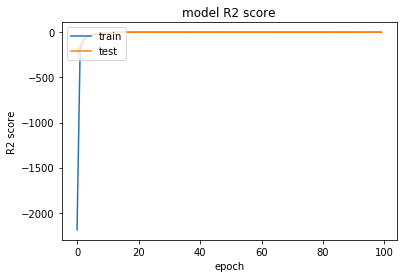

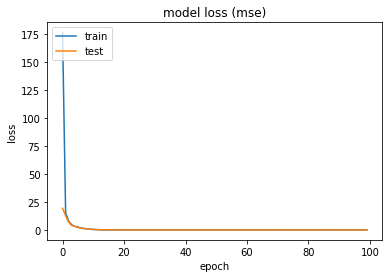

In [47]:
%matplotlib inline

plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model R2 score')
plt.ylabel('R2 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()